In [97]:
import numpy as np
from fluids import FluidsList
import matplotlib.pyplot as plt
Air = FluidsList.Air
def turb_outlet_pressure(core_pressure, mdot, R2, R3, L, T_PM):
    "Returns turbine outlet pressure P1 and SiC inner wall pressure P2"
    P2 = core_pressure
    PMstate = Air(T=T_PM, P=P2) # Fluid state
    Q= mdot / PMstate.rho # Volumetric flow rate [m^3/s]
    
    A = 2*np.pi*R3*L # Cross sectional area [m^2]
    vs = Q / A # Darcian velocity [m/s]
    k1 = 5.69771546674471E-12 # for 18% open porosity, 35% total
    k2 = np.exp(-1.71588/(k1**0.08093)) # Correlation from Dey et al.
    P1 = np.sqrt((PMstate.mu*vs/k1 + (PMstate.rho*vs**2)/k2) * 2*P2*(R3-R2) + P2**2) # Inlet pressure to PM [Pa]
    return P1, P2

mdot = .015
R1 = .0877/2
R2 = .049
L = .4
T_PM = 300
mdots = []; Ps = []
for i in range(200):
    mdot = i/1e4
    mdots.append(mdot)
    P = turb_outlet_pressure(101325, mdot, R1, R2, L, T_PM)
    Ps.append(P[0])


Text(0.5, 0, 'Mass Flow (kg/s)')

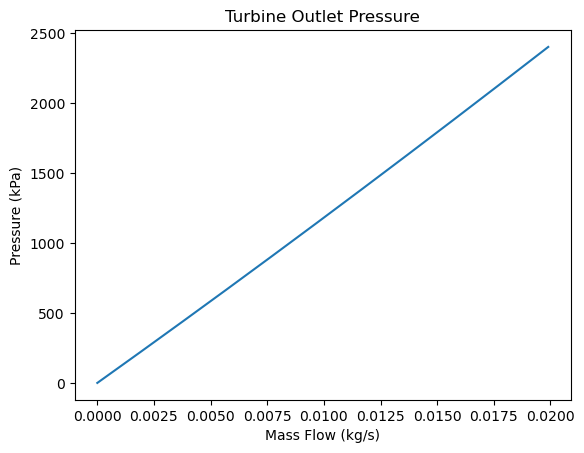

In [98]:
plt.plot(mdots, np.array(Ps)-101325)
plt.title("Turbine Outlet Pressure")
plt.ylabel("Pressure (kPa)")
plt.xlabel("Mass Flow (kg/s)")

In [99]:
R_id = 287
P0 = 101325
T = 300
base = Air(P=P0, T=300)
mu = base.mu
density = lambda P: P/(R_id*T)
Rho = density(P0)
mass_flows = np.arange(0,.02,1e-3)
pvals = []
n = 400
for Mdot in mass_flows:
    r1 = .049
    r2 = .051
    L = 0.4
    Ar = 2*np.pi*r1*L           # PM radial surface area
    Ax = np.pi * (r2**2-r1**2)  # axial cross-section area
    dx = L/n                    # cell length
    def pgrad(u, rho, R, r):
        "Finds axial pressure gradient from axial velocity"
        s = (R - r)
        Re_ax = rho*u*s/mu
        Re_w = rho*u*s/mu
        for x in range(Re_w.shape[0]):
            if Re_w[x]<960:
                Re_w[x]=960
        frac = ((7/8)*(Re_w/(2*Re_ax)))
        Cf = 0.26 * Re_ax**-0.24 * (1 + frac**2)**0.38
        dPdx = Cf*rho/(4*s)*u**2
        #print("GRADIENT", frac[0], Cf[0])
        return dPdx

    def v_PM(P, rho):
        k1 = 5.69771546674471E-12 # for 18% open porosity, 35% total
        k2 = np.exp(-1.71588/(k1**0.08093)) # Correlation from Dey et al.
        r0 = .0877/2
        dR = r1-r0
        A = 2*P0*dR*rho/k2
        B = 2*P0*dR*mu/k1 
        C = P0**2 - P**2
        vs = (-B + np.sqrt(B**2-4*A*C))/(2*A)
        return vs
    rrsum = lambda vec: np.flip(np.cumsum(np.flip(vec)))

    P = np.array([105e3]*n)
    x = np.arange(n)*dx
    rho = np.array([Rho]*n)
    v = v_PM(P,rho)
    mdy = (v * Ar/n) * rho
    mdx = rrsum(mdy)
    u = (mdx/rho)/Ax
    #dP = pgrad(u, rho, r2, r1)
    Pmin = min(P)
    step = 1e4
    tol = 1e-6
    i=0
    while abs(Mdot - mdx[0])>tol:
        dP = pgrad(u, rho, r2, r1)
        Pax = rrsum(dP)*dx
        Pmin = Pmin + step*(Mdot - mdx[0])
        P = Pmin + Pax
        rho = density(P)
        v = v_PM(P, rho)
        mdy = (v * Ar/n) * rho
        mdx = rrsum(mdy)
        u = (mdx/rho)/Ax
    pvals.append(P[0])

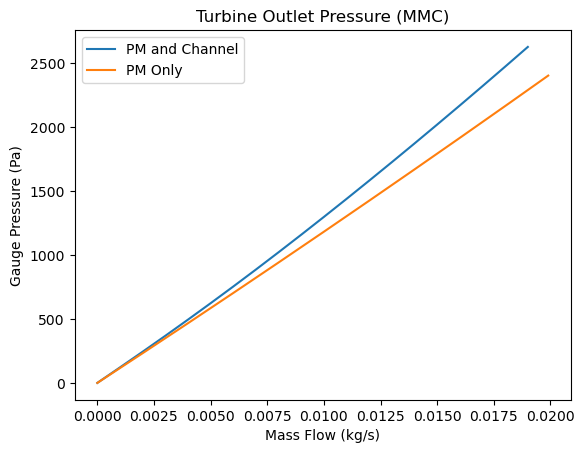

In [100]:
plt.plot(mass_flows,np.array(pvals)-P0, label="PM and Channel")
plt.plot(mdots, np.array(Ps)-P0, label="PM Only")
plt.title("Turbine Outlet Pressure (MMC)")
plt.ylabel("Gauge Pressure (Pa)")
plt.xlabel("Mass Flow (kg/s)")
plt.legend()